In [1]:
# https://docs.opencv.org/3.4/d1/dc5/tutorial_background_subtraction.html
import cv2
import numpy as np
import json
import shutil
import os
import glob
from matplotlib import pyplot as plt
from scipy import ndimage
import cv2 as cv
import random
from itertools import groupby
import seaborn as sns
from operator import itemgetter 
from sklearn.model_selection import train_test_split
from pathlib import Path
random.seed(42)

In [2]:
basepath = '../data/islands/images/images/' # refactor to match path naming
metadata_path = '../data/islands/metadata.json'
seq_path = 'c:/temp/islands64/'
with open(metadata_path) as f:
    d = json.load(f)

In [3]:
d['categories']

[{'id': 0, 'name': 'empty'},
 {'id': 1, 'name': 'human'},
 {'id': 2, 'name': 'fox'},
 {'id': 3, 'name': 'skunk'},
 {'id': 4, 'name': 'rodent'},
 {'id': 5, 'name': 'bird'},
 {'id': 6, 'name': 'other'}]

In [4]:
d['images']

[{'id': 'dd8b68e9-360b-429e-a43b-892c2e036455',
  'file_name': 'loc-h500ee07133376/000/000.jpg',
  'seq_id': '836f6487-50fd-42f5-8dcc-336fc538b7a8',
  'seq_num_frames': 6,
  'frame_num': 0,
  'original_relative_path': '2011_09_Set/Station%201/2011/2011-09-13/IMG_0001.JPG',
  'location': 'h500ee07133376',
  'temperature': '21 c',
  'width': 1920,
  'height': 1080},
 {'id': '46619c4d-2d36-4cca-9cd6-933c669a44ab',
  'file_name': 'loc-h500ee07133376/000/001.jpg',
  'seq_id': '836f6487-50fd-42f5-8dcc-336fc538b7a8',
  'seq_num_frames': 6,
  'frame_num': 1,
  'original_relative_path': '2011_09_Set/Station%201/2011/2011-09-13/IMG_0002.JPG',
  'location': 'h500ee07133376',
  'temperature': '21 c',
  'width': 1920,
  'height': 1080},
 {'id': '62782485-48ed-4da7-b795-7af43393aaf1',
  'file_name': 'loc-h500ee07133376/000/002.jpg',
  'seq_id': '836f6487-50fd-42f5-8dcc-336fc538b7a8',
  'seq_num_frames': 6,
  'frame_num': 2,
  'original_relative_path': '2011_09_Set/Station%201/2011/2011-09-13/IMG_000

In [5]:
d['annotations']

[{'id': '16e360cc-4a53-11eb-b9b3-000d3a74c7de',
  'image_id': 'dd8b68e9-360b-429e-a43b-892c2e036455',
  'category_id': 0,
  'sequence_level_annotation': False,
  'bbox': [0, 0, 1919, 1079]},
 {'id': '16e360cd-4a53-11eb-97ff-000d3a74c7de',
  'image_id': '46619c4d-2d36-4cca-9cd6-933c669a44ab',
  'category_id': 0,
  'sequence_level_annotation': False,
  'bbox': [0, 0, 1919, 1079]},
 {'id': '16e360ce-4a53-11eb-832e-000d3a74c7de',
  'image_id': '62782485-48ed-4da7-b795-7af43393aaf1',
  'category_id': 0,
  'sequence_level_annotation': False,
  'bbox': [0, 0, 1919, 1079]},
 {'id': '16e360cf-4a53-11eb-9447-000d3a74c7de',
  'image_id': 'c4465075-477d-45b2-be07-fad35b2fec2c',
  'category_id': 1,
  'sequence_level_annotation': False,
  'bbox': [0, 657, 1919, 391]},
 {'id': '16e360d0-4a53-11eb-90ec-000d3a74c7de',
  'image_id': '7e2b120a-78ef-4c06-bdae-4f4070acf05e',
  'category_id': 0,
  'sequence_level_annotation': False,
  'bbox': [0, 0, 1919, 1079]},
 {'id': '16e360d1-4a53-11eb-bc2c-000d3a74c7d

In [3]:
# remove humans and images that are not in a sequence. 
human_imageid = [i.get('image_id') for i in d['annotations'] if i.get('category_id') == 1] #5981 human labeled. 
noseq_imageid = [i.get('id') for i in d['images'] if i.get('seq_num_frames') <= 2]
id_filter = set(noseq_imageid + human_imageid)
d['annotations'] = [i for i in d['annotations'] if i.get('image_id') not in id_filter]
d['images'] = [i for i in d['images'] if i.get('id') not in id_filter]

In [4]:
# change the category id of other to human
for anno in d['annotations']:
    if anno.get('category_id') == 6:
        anno['category_id'] = 1

some EDA

In [5]:
from collections import Counter
c = Counter([i.get('seq_num_frames') for i in d['images']])
c.most_common()

[(3, 50949),
 (10, 41433),
 (6, 21322),
 (20, 17669),
 (9, 10153),
 (30, 8574),
 (12, 6508),
 (15, 4767),
 (4, 4652),
 (40, 4377),
 (18, 3506),
 (60, 3115),
 (5, 2951),
 (50, 2698),
 (21, 2369),
 (24, 2246),
 (7, 1875),
 (27, 1642),
 (8, 1606),
 (70, 1330),
 (90, 1260),
 (36, 1245),
 (33, 1089),
 (39, 955),
 (42, 838),
 (120, 838),
 (11, 809),
 (741, 741),
 (80, 720),
 (14, 693),
 (669, 669),
 (63, 581),
 (16, 560),
 (45, 542),
 (17, 519),
 (13, 484),
 (480, 480),
 (57, 456),
 (23, 451),
 (438, 438),
 (435, 435),
 (48, 399),
 (51, 357),
 (81, 356),
 (19, 339),
 (84, 336),
 (110, 330),
 (160, 320),
 (75, 300),
 (100, 300),
 (96, 288),
 (54, 275),
 (270, 270),
 (130, 259),
 (255, 255),
 (41, 245),
 (22, 240),
 (240, 240),
 (78, 234),
 (114, 228),
 (69, 207),
 (102, 204),
 (31, 182),
 (170, 170),
 (159, 159),
 (25, 150),
 (149, 149),
 (72, 144),
 (141, 141),
 (138, 138),
 (66, 132),
 (29, 127),
 (126, 126),
 (105, 105),
 (99, 105),
 (32, 96),
 (47, 94),
 (34, 92),
 (44, 88),
 (87, 87),
 (

In [8]:
from collections import Counter
c = Counter([i.get('category_id') for i in d['annotations']])
c.most_common()

[(0, 102230), (4, 77759), (2, 44337), (5, 9284), (3, 957), (1, 144)]

# start dataset build

In [5]:
for i in range(len(d['images'])):
    d['images'][i]['image_id'] = d['images'][i].pop('id')

my_id = itemgetter('image_id')
meta_anno = []

for k, v in groupby(sorted((d['annotations'] + d['images']), key=my_id), key=my_id):
    meta_anno.append({key:val for d in v for key, val in d.items()})

I want to make sure that I stratify by all categories found in the sequence..

In [6]:
def get_ordered_sequence_categories(dataset, all_sequences):
    imgs_seq_lookup = {}
    for ma in dataset:
        imgs_seq_lookup.setdefault(ma.get('seq_id','empty'),[]).append(ma)
    orderedseqcats = []
    for seq in all_sequences: 
        cats = [i.get('category_id') for i in imgs_seq_lookup.get(seq)]

        # the following logic finds the most frequent category, not including 'empty'. 
        catsnozero = [c for c in cats if c != 0]
        if not catsnozero:  
            maxcats = 0
        else: 
             maxcats = max(set(catsnozero), key=catsnozero.count)

        orderedseqcats.append(maxcats)
    return orderedseqcats

In [7]:
all_sequences = list(set([i.get('seq_id') for i in meta_anno]))
full_length = len(all_sequences)
orderedseqcats = get_ordered_sequence_categories(meta_anno,all_sequences)
labels = [i for i in orderedseqcats]
trainseqs, testseqs = train_test_split(all_sequences, test_size=(full_length//5), random_state=42, stratify=labels)

In [9]:
# co-occurence of labels in sequences
c = Counter(s for s in orderedseqcats)
print(c)

Counter({0: 15754, 4: 8748, 2: 5267, 5: 1564, 3: 177, 1: 32})


In [8]:
train_meta_anno, test_meta_anno = [], []
trainseqset, testseqset = set(trainseqs), set(testseqs) # O(1) lookup
for ma in meta_anno: 
    if ma.get('seq_id') in trainseqset:
        train_meta_anno.append(ma)
    elif ma.get('seq_id') in testseqset:
        test_meta_anno.append(ma)

In [9]:
all_sequences75 = list(set([i.get('seq_id') for i in train_meta_anno]))
full_length10 = len(all_sequences75)
orderedseqcats10 = get_ordered_sequence_categories(train_meta_anno,all_sequences75)
labels = orderedseqcats10
train_10, _ = train_test_split(all_sequences75, test_size=(int(full_length10*0.90)), random_state=42, stratify=labels)

In [10]:
train10_meta_anno = []
trainseqset = set(train_10) # O(1) lookup
for ma in meta_anno: 
    if ma.get('seq_id') in trainseqset:
        train10_meta_anno.append(ma)

In [11]:

ids = [os.path.split(i)[1].split('.jpg')[0] for i in glob.glob("c:/temp/islands64/" + '/*.jpg', recursive=True)]

In [12]:
ids2 = [j.get('image_id') for j in train10_meta_anno]
ids3 = [i for i in ids if i not in ids2]

In [13]:
len(ids3)

15972

In [35]:
for f in ids3:
    os.remove('c:/temp/islands64/' + f + '.jpg')

In [15]:
len(train_metaanno), len(all_sequences75), len(orderedseqcats10), full_length10, len(train10_meta_anno)

(174209, 25234, 25234, 25234, 16939)

Creating background sub with train10 to test...

In [22]:
train10_meta_anno[0]

{'id': '17e7424d-4a53-11eb-b22b-000d3a74c7de',
 'image_id': '00035273-df2a-476e-8d3e-d8be0a8c9b49',
 'category_id': 0,
 'sequence_level_annotation': False,
 'bbox': [0, 0, 2047, 1535],
 'file_name': 'loc-h500ee11142487/008/165.jpg',
 'seq_id': '05f12a90-0a77-4d0f-825b-8902bda5cce5',
 'seq_num_frames': 255,
 'frame_num': 80,
 'original_relative_path': '2013_03_Set/card3/101RECNX/IMG_5148.JPG',
 'location': 'h500ee11142487',
 'temperature': '18 c',
 'width': 2048,
 'height': 1536}

In [16]:
# from backgroundsubseq import generate_boxed_by_sequence

In [7]:
from tqdm import tqdm

In [15]:
import cv2
import numpy as np
import json
import shutil
import os
import glob
from matplotlib import pyplot as plt
from scipy import ndimage
import cv2 as cv
import PIL


def getSequenceBGSub(seq_images):
    bgs = []
    fgbg = cv2.createBackgroundSubtractorMOG2(detectShadows=True)
    kernel = np.ones((5, 5), np.uint8)
    kernel2 = np.ones((3, 3), np.uint8)
    for im in seq_images:
        backgroundsubbed = fgbg.apply(im)
        backgroundsubbed = cv2.erode(backgroundsubbed, kernel)
        backgroundsubbed = cv2.dilate(backgroundsubbed, kernel2)
        backgroundsubbed = cv2.erode(backgroundsubbed, kernel)
        backgroundsubbed = cv2.dilate(backgroundsubbed, kernel2)
        bgs.append(backgroundsubbed)
    # also sub the first image
    fgbg = cv2.createBackgroundSubtractorMOG2(detectShadows=True)
    fgbg.apply(seq_images[-1])
    backgroundsubbed = fgbg.apply(seq_images[0])
    backgroundsubbed = cv2.erode(backgroundsubbed, kernel)
    backgroundsubbed = cv2.dilate(backgroundsubbed, kernel2)
    backgroundsubbed = cv2.erode(backgroundsubbed, kernel)
    backgroundsubbed = cv2.dilate(backgroundsubbed, kernel2)    
    bgs[0] = backgroundsubbed
    return bgs

def getBox(src):
    # https://stackoverflow.com/questions/60646384/python-opencv-background-subtraction-and-bounding-box
    src_gray = cv.cvtColor(src,cv.COLOR_BGR2GRAY)

    # adjust brightness
    src_bright = cv.convertScaleAbs(src_gray, alpha = 255.0/src.max(), beta = 0)
    # apply threshold
    threshold = 50
    _, img_thresh = cv.threshold(src_bright, threshold, 255, 0)
    # apply erode
    erosion_size = 7
    erosion_type = cv.MORPH_ELLIPSE
    element = cv.getStructuringElement(erosion_type, (2*erosion_size + 1, 2*erosion_size+1), (erosion_size, erosion_size))
    img_erosion = cv.erode(img_thresh, element)
    # apply dilate
    dilatation_size = 17
    dilatation_type = cv.MORPH_ELLIPSE
    element = cv.getStructuringElement(dilatation_type, (2*dilatation_size + 1, 2*dilatation_size+1), (dilatation_size, dilatation_size))
    img_dilate = cv.dilate(img_erosion, element)

    # apply canny and find contours
    threshold = 50
    canny_output = cv.Canny(img_dilate, threshold, threshold * 2)
    contours, _ = cv.findContours(canny_output, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

    xmax = ymax = 1
    xmin = ymin = 99999
    for c in contours:
        for cs in c:
            x, y = cs[0]
            if x > xmax: xmax = x
            if x < xmin: xmin = x
            if y > ymax: ymax = y
            if y < ymin: ymin = y
    return xmin, xmax, ymin, ymax


def letterbox(im, new_shape=(640, 640), color=(114, 114, 114), auto=True, scaleFill=False, scaleup=True, stride=32):
    # Resize and pad image while meeting stride-multiple constraints
    shape = im.shape[:2]  # current shape [height, width]
    if isinstance(new_shape, int):
        new_shape = (new_shape, new_shape)

    # Scale ratio (new / old)

    r = min(new_shape[0] / shape[0], new_shape[1] / shape[1])
    if not scaleup:  # only scale down, do not scale up (for better val mAP)
        r = min(r, 1.0)


    # Compute padding
    ratio = r, r  # width, height ratios
    new_unpad = int(round(shape[1] * r)), int(round(shape[0] * r))
    dw, dh = new_shape[1] - new_unpad[0], new_shape[0] - new_unpad[1]  # wh padding
    if auto:  # minimum rectangle
        dw, dh = np.mod(dw, stride), np.mod(dh, stride)  # wh padding
    elif scaleFill:  # stretch
        dw, dh = 0.0, 0.0
        new_unpad = (new_shape[1], new_shape[0])
        ratio = new_shape[1] / shape[1], new_shape[0] / shape[0]  # width, height ratios

    dw /= 2  # divide padding into 2 sides
    dh /= 2

    if shape[::-1] != new_unpad:  # resize
        im = cv2.resize(im, new_unpad, interpolation=cv2.INTER_LINEAR)
    top, bottom = int(round(dh - 0.1)), int(round(dh + 0.1))
    left, right = int(round(dw - 0.1)), int(round(dw + 0.1))
    im = cv2.copyMakeBorder(im, top, bottom, left, right, cv2.BORDER_CONSTANT, value=color)  # add border
    return im, ratio, (dw, dh)


def generate_boxed_by_sequence(seq_paths: list, size: int):
    # seq_images = [cv2.imread(img) for img in seq_paths]
    seq_images = [np.array(PIL.Image.open(img)) for img in seq_paths]
    bgs = getSequenceBGSub(seq_images)
    imgs = []
    for i, bg in enumerate(bgs):
        width, height = bg.shape
        boolbackground = bg != 0
        img = seq_images[i]
        img_booled = img * boolbackground[..., np.newaxis]
        xmin, xmax, ymin, ymax = getBox(img_booled)
        if (xmax-xmin) < 10 or (ymax - ymin) < 10:
            reshaped_img = img
        else:
            xmin, xmax = max(xmin-15, 1), min(xmax+15, width)
            ymin, ymax = max(ymin-15, 1), min(ymax+15, height)
            reshaped_img = img[ymin:ymax, xmin:xmax, :]
            if 0 in reshaped_img.shape or reshaped_img is None: reshaped_img = img
        imgs.append(reshaped_img)
        imgs = [letterbox(im, size, auto=False)[0] for im in imgs]
    return imgs


In [17]:
sequences_train10 = list(set([i.get('seq_id') for i in train10_meta_anno]))
imgs_seq_lookup = {}
for ma in train10_meta_anno:
    imgs_seq_lookup.setdefault(ma.get('seq_id','empty'),[]).append(ma)
# for sequence in tqdm(sequences_train10[390:400]):
for sequence in tqdm(sequences_train10):
    filenames = [i.get('file_name') for i in imgs_seq_lookup.get(sequence)]
    ids = [i.get('image_id') for i in imgs_seq_lookup.get(sequence)]
    p = lambda x: str(Path(basepath) / x)
    paths = [p(x) for x in filenames]
    imgs = generate_boxed_by_sequence(paths, 224)
    for im, fn in zip(imgs, ids):
        cv2.imwrite(seq_path + fn + '.jpg', im)

  0%|          | 3/2524 [00:04<51:30,  1.23s/it]  C:\Users\jakob\AppData\Local\Temp\ipykernel_15672\2243143619.py:42: RuntimeWarning: divide by zero encountered in true_divide
  src_bright = cv.convertScaleAbs(src_gray, alpha = 255.0/src.max(), beta = 0)
100%|██████████| 2524/2524 [56:08<00:00,  1.33s/it]  


In [22]:
import pickle
with open('c:/temp/train10_meta_anno.pk', 'wb') as f:
    pickle.dump(train10_meta_anno, f, protocol=pickle.HIGHEST_PROTOCOL)

In [24]:

with open('c:/temp/test_meta_anno.pk', 'wb') as f:
    pickle.dump(test_meta_anno, f, protocol=pickle.HIGHEST_PROTOCOL)

In [19]:
imgs = generate_boxed_by_sequence(testpath, 64)

c:\Projects\wild\notebooks_misc\backgroundsubseq.py:39: RuntimeWarning: divide by zero encountered in true_divide
  src_bright = cv.convertScaleAbs(src_gray, alpha = 255.0/src.max(), beta = 0)


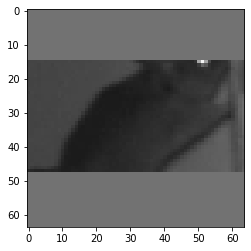

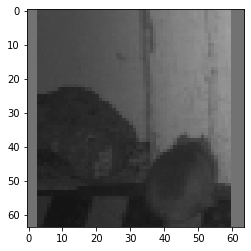

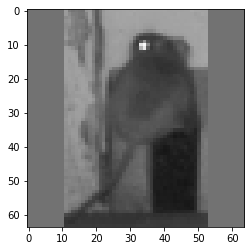

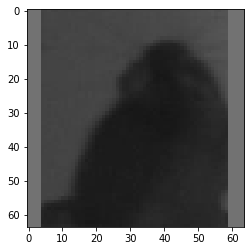

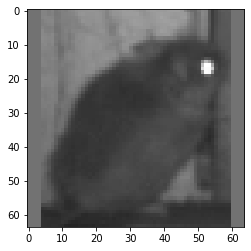

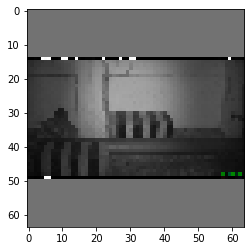

In [42]:
for im in imgs: 
    plt.imshow(im)
    plt.show()

In [94]:
    len(train_10)

2524

In [ ]:
for subset, name in zip(trainsubsets + [validate, test], ('train100', 'train50', 'train20', 'train10', 'train5', "val", "test")):
    location_counter = {}
    sequence_counter = {}
    species_counter = {}
 
    for img in subset:
        location_counter[img.get('location')] = location_counter.get(img.get('location'), 0) + 1
        sequence_counter[img.get('seq_num_frames')] = sequence_counter.get(img.get('seq_num_frames'), 0) + 1
        species_counter[img.get('category_id')] = species_counter.get(img.get('category_id'), 0) + 1

    species_lookup = {i.get('id') : i.get('name') for i in d['categories']}
    species_named_counter = {species_lookup.get(k): v for k, v in species_counter.items()}

    plt.figure(num=None, figsize=(5,4), dpi=80, facecolor='w', edgecolor='r')
    y = list(species_named_counter.keys())
    x = list(species_named_counter.values())
    argx = np.argsort(x)[::-1]
    x = np.array(x)[argx]
    y = np.array(y)[argx]
    plt.title(name)
    p = sns.barplot(x = x, y = y)
    show_values(p, "h", space=0)
    plt.show()